Data from Rossetto et al 2015: [Where did all the trees come from? A novel multispecies approach reveals the impacts of biogeographical history and functional diversity on rain forest assembly](https://onlinelibrary.wiley.com/doi/full/10.1111/jbi.12571) [Dryad](http://www.datadryad.org:8080/handle/10255/dryad.91657?show=full)

A related paper: [Assemblage Accumulation Curves: A framework for resolving species accumulation in biological communities using chloroplast genome sequences chloroplast genome sequences.](https://sci-hub.tw/10.1111/2041-210X.13181)

### Triat data
Fetch continuous trait data from [supporting information](https://onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1111%2Fjbi.12571&file=jbi12571-sup-0001-AppendixS1-S3.docx). I copied this from the supporting doc and then pasted it into a google sheet, which was smart enough to retain proper column orientation and formatting. Then I exported to a csv for downstream.

### Genetic data
Fetch the zip file from dryad (doi: 10.5061/dryad.j64j0). 

### Tweaks
* All these species names in the trait data had to be modified to match the names of the fasta files. I just did it by hand inside the csv:
```
    Daphnandra apatela (sp McPherson Range)  
    Caldcluvia paniculosa /Ackama paniculata  
    Endiandra muelleri ssp. muelleri  
    Planchonella australis/ Pouteria australis  
```
* Fixing disagreements between the trait and fasta species names:
```
    Arcadenia eudiiformis
        Fasta error. Species name is Acradenia euodiiformis and is correct in the trait
        data so i renamed these in the fasta.
    Neolitsea suatraliensis
        Typo in the fasta file. Renamed to agree with Neolitsea austarliensis
    Pouteria australia
        Copied the row in the trait file for Planchonella australis and 
        renamed to Pouteria australia to match the fasta
    Wilkea huegeliana
        In the trait file renamed Wilkiea huegeliana to Wilkea huegeliana
    Alphitona excelsa
        Fasta names were wrong. Fixed to Alphitonia excelsa
    Diploglottis australis
        The sequence names inside the Diploglottis cunninghamii fasta file. They are synonyms.
        It is Diploglottis cunninghamii in the trait file so renamed the fasta seqs.
    Doryphora sassafras
        Trait file had Doryphora sassasfras, which is incorrect. Fixed the name in the trait file.
    Neolitsea austarliensis
        Another typo in the fasta. Should be Neolitsea australiensis.
```
* Inside the dryad zip file is a directory called "Fasta Alignments for DRYAD". Rename this to remove spaces.

* Trochocarpa laurina had two sequences that did not have locality info. I counted # segregating sites for each and used the info in the supplement to identify and rename these two samples. I renamed these sequences by hand in the appropriate fasta file, just to fix them forever:

    '>Trochocarpa_laurina_S_M89' -> '>Trochocarpa_laurina_D'
    '>Trochocarpa_laurina' -> '>Trochocarpa_laurina_N'

In [83]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from IPython.display import display
from scipy.stats import hmean
from sklearn.decomposition import PCA

import MESS

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get trait data per species

,Family,Species,Seed dry mass_log10,Maximum leaf area_log10,Maximum height_log10,Maximum fruit length_log10,Wood density_log10
0,Apocynaceae,Tabernaeamontana pandacaqui,1.438730,3.845098,0.602060,1.698970,2.674861
1,Araliaceae,Polyscias elegans,0.017472,3.836324,1.477121,0.845098,2.602060
2,Araliaceae,Polyscias murrayi,0.538133,3.702431,1.477121,0.698970,2.431364
3,Araliaceae,Polyscias sambucifolius,0.322039,3.577492,0.602060,0.778151,2.579784
4,Atherospermataceae,Daphnandra apatela,0.789557,3.623249,1.544068,1.397940,2.747917


('Explained variance', array([0.8486093 , 0.16524436]))


,trait
Species,
Tabernaeamontana pandacaqui,-0.351259
Polyscias elegans,1.179464
Polyscias murrayi,0.730552
Polyscias sambucifolius,0.974805
Daphnandra apatela,0.315916


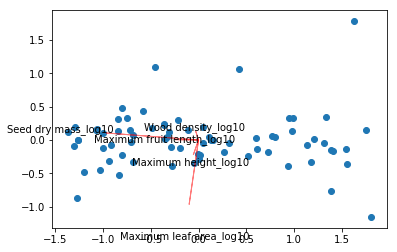

In [2]:
trt_dat = pd.read_csv("Rossetto_etal_2015/trait_data.csv", header=0)
display(trt_dat.iloc[:5])
pca = PCA(n_components=2)
dat = pca.fit_transform(trt_dat.iloc[:, 2:])
plt.scatter(dat[:, 0], dat[:, 1])
print("Explained variance", pca.explained_variance_)
for i, comp in enumerate(pca.components_.T):
    plt.arrow(0, 0, pca.components_.T[i,0], pca.components_.T[i,1],color = 'r',alpha = 0.5)
    plt.text(pca.components_.T[i,0]* 1.5, pca.components_.T[i,1] * 1.5, trt_dat.columns[i+2], color = 'black', ha = 'center', va = 'center')
trait_df = pd.DataFrame(dat[:, 0], index=trt_dat["Species"], columns=["trait"])
display(trait_df[:5])


## Get genetic data per species

In [3]:
## Put all the fasta files in one big file to reduce housekeeping
!cat Rossetto_etal_2015/Fasta_Alignments_for_DRYAD/*.fasta > Rossetto_etal_2015/All.fasta
fastas = map(lambda x: x.strip(), open("Rossetto_etal_2015/All.fasta").readlines())
print(fastas[0].strip())

## The site names and a dictionary for holding the fasta data per site
locs = ["Dorrigo", "Nightcap", "Washpool"]
fastas_by_loc_dfs = {loc:dict() for loc in locs}

pairdealer = itertools.izip(*[iter(fastas)]*2)
done = False
while not done:
    try:
        name, seq = pairdealer.next()
        if "_D" in name:
            fastas_by_loc_dfs["Dorrigo"][name] = seq
        elif "_N" in name:
            fastas_by_loc_dfs["Nightcap"][name] = seq
        elif "_W" in name:
            fastas_by_loc_dfs["Washpool"][name] = seq
        else:
            print("Found an unlabeled sequence name.")
            print(name)
            c = Counter(seq)
            for i in ["A", "C", "G", "T", "-", "?", "N", "\n"]:
                try:
                    c.pop(i)
                except:
                    pass
            print("N segsites", sum(c.values()))

    except StopIteration:
        done = True

>Acacia_melanoxylon_D


In [11]:
## Genomic diversity per site for each species within each sampling
## location. Munging the name to make it agree with the species name
## in the trait_df. Drop the trailing _*, convert '_' to space and
## drop the leading '>':
##   e.g. >Acacia_melanoxylon_N becomes Acacia melanoxylon
diversity_by_loc_dfs = {loc:dict() for loc in locs}
for loc in locs:
    diversity_by_loc_dfs[loc] = {name.rsplit("_", 1)[0].replace("_", " ").replace(">", ""):MESS.stats.Watterson(seq) for name, seq in fastas_by_loc_dfs[loc].items()}


## Combine trait and genetic data per site

In [12]:
## Make a dataframe from the dictionary
washpool_df = pd.DataFrame.from_dict(diversity_by_loc_dfs["Washpool"], orient='index', columns=["pi"])
## Paste on the trait values per species
washpool_df = pd.concat([washpool_df, trait_df], axis=1, sort=True)
## Drop all rows that are Nan in the pi column (species not from this location)
washpool_df = washpool_df[~pd.isna(washpool_df)["pi"]]
washpool_df.to_csv("Washpool.csv")

In [13]:
## Make a dataframe from the dictionary
dorrigo_df = pd.DataFrame.from_dict(diversity_by_loc_dfs["Dorrigo"], orient='index', columns=["pi"])
## Paste on the trait values per species
dorrigo_df = pd.concat([dorrigo_df, trait_df], axis=1, sort=True)
## Drop all rows that are Nan in the pi column (species not from this location)
dorrigo_df = dorrigo_df[~pd.isna(dorrigo_df)["pi"]]
dorrigo_df.to_csv("Dorrigo.csv")

In [14]:
## Make a dataframe from the dictionary
nightcap_df = pd.DataFrame.from_dict(diversity_by_loc_dfs["Nightcap"], orient='index', columns=["pi"])
## Paste on the trait values per species
nightcap_df = pd.concat([nightcap_df, trait_df], axis=1, sort=True)
## Drop all rows that are Nan in the pi column (species not from this location)
nightcap_df = nightcap_df[~pd.isna(nightcap_df)["pi"]]
nightcap_df.to_csv("Nightcap.csv")

In [15]:
## Make sure all trait data cells are populated
nightcap_df[pd.isna(nightcap_df)["trait"]]
dorrigo_df[pd.isna(dorrigo_df)["trait"]]
washpool_df[pd.isna(washpool_df)["trait"]]

,pi,trait


(53, 0.00012933192720155834)
(51, 9.632296041228422e-05)
(53, 6.027581006271792e-05)


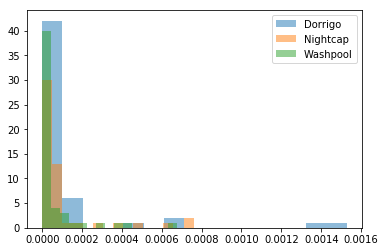

In [149]:
for name, df in zip(locs, [dorrigo_df, nightcap_df, washpool_df]):
    print(len(df), np.mean(df["pi"]))
    _, _, _ = plt.hist(df["pi"], label=name, alpha=0.5, bins=15)
plt.legend()

In [148]:
wat = False
print(wat)
wat = not wat
print(wat)



False
True
